# Optimizing training and inference

In this notebook, we will discuss different ways to reduce memory and compute usage during training and inference.

## Prepare training script (1 point)

When training large models, it is usually a best practice not to use Jupyter notebooks, but run a **separate script** for training which could have command-line flags for various hyperparameters and training modes. This is especially useful when you need to run multiple experiments simultaneously (e.g. on a cluster with task scheduler). Another advantage of this is that after training, the process will finish and free the resources for other users of a shared GPU.

In this part, you will need to put all your code to train a model on Tiny ImageNet that you wrote for the previous task in `train.py`.

You can then run your script from inside of this notebook like this:

In [129]:
!python train.py --epochs=2 --batch=200 --batch_count=5 --memory_usage --plot_hist

## DONE! 

Whole lot of code goes to files
- train.py
- utils.py
- cls_models.py
- dataset.py

**Task** 

Write code for training with architecture from homework_part2

**Requirements**
* Optional arguments from command line such as batch size and number of epochs with built-in argparse
* Modular structure - separate functions for creating data generator, building model and training 


## Profiling time (1 point)

For the next tasks, you need to add measurements to your training loop. You can use [`perf_counter`](https://docs.python.org/3/library/time.html#time.perf_counter) for that:

In [1]:
import time
import numpy as np
import torch

In [4]:
x = np.random.randn(1000, 1000)
y = np.random.randn(1000, 1000)

start_counter = time.perf_counter()
z = x @ y
elapsed_time = time.perf_counter() - start_counter
print("Matrix multiplication took {:.3f} seconds".format(elapsed_time))

Matrix multiplication took 0.052 seconds


**Task**. You need to add the following measurements to your training script:
* How much time a forward-backward pass takes for a single batch;
* How much time an epoch takes.

# DONE! 

Create a useful class Profiler - for profiling time of different tasks

At cell below example of program logging 


In [1]:
!python train.py --epochs=2 --batch=200

Logging Timestamp 2020-03-09 13.00.28

Namespace(batch=200, batch_count=1, checkpoint=-1, epochs=2, memory_usage=False, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 13.00.28.txt', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 200
Run training
Epoch [1/2] Time: 71.07s; BatchTime:0.15s; Loss: 4.2169; Accuracy: 0.1175; ValLoss: 3.8208; ValAccuracy: 0.1678
Epoch [2/2] Time: 70.93s; BatchTime:0.15s; Loss: 3.3600; Accuracy: 0.2499; ValLoss: 3.2819; ValAccuracy: 0.2638

TEST Loss: 3.2794; Accuracy: 0.2632




## Profiling memory usage (1 point)

**Task**. You need to measure the memory consumptions

This section depends on whether you train on CPU or GPU.

### If you train on CPU
You can use GNU time to measure peak RAM usage of a script:

In [ ]:
!/usr/bin/time -lp python train.py

**Maximum resident set size**  will show you the peak RAM usage in bytes after the script finishes.

**Note**. 
Imports also require memory, do the correction

### If you train on GPU

Use [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/cuda.html#torch.cuda.max_memory_allocated) at the end of your script to show the maximum amount of memory in bytes used by all tensors.

# DONE! 
To enable displaying `memory usage` you should add flag `--memory_usage`

In [2]:
!python train.py --epochs=2 --batch=200 --memory_usage

Logging Timestamp 2020-03-09 13.06.23

Namespace(batch=200, batch_count=1, checkpoint=-1, epochs=2, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 13.06.23.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 200
Run training
Epoch [1/2] Time: 71.54s; BatchTime:0.15s; Loss: 4.2160; Accuracy: 0.1175; ValLoss: 3.7632; ValAccuracy: 0.1828
Epoch [2/2] Time: 71.08s; BatchTime:0.15s; Loss: 3.3775; Accuracy: 0.2438; ValLoss: 3.2805; ValAccuracy: 0.2594

TEST Loss: 3.2741; Accuracy: 0.2609

Peak memory usage by Pytorch tensors: 1500.44 Mb



## Gradient based techniques

Modern architectures can potentially consume lots and lots of memory even for minibatch of several objects. To handle such cases here we will discuss two simple techniques.

### Gradient Checkpointing (3 points)

Checkpointing works by trading compute for memory. Rather than storing all intermediate activations of the entire computation graph for computing backward, the checkpointed part does not save intermediate activations, and instead recomputes them in backward pass. It can be applied on any part of a model.

See [blogpost](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9) for kind introduction and different strategies or [article](https://arxiv.org/pdf/1604.06174.pdf) for not kind introduction.

**Task**. Use [built-in checkpointing](https://pytorch.org/docs/stable/checkpoint.html), measure the difference in memory/compute 

**Requirements**. 
* Try several arrangements for checkpoints
* Add the chekpointing as the optional flag into your script
* Measure the difference in memory/compute between the different arrangements and baseline 

In [5]:
#baseline 
!python train.py --epochs=15 --batch=600 --memory_usage

Logging Timestamp 2020-03-09 13.40.47

Namespace(batch=600, batch_count=1, checkpoint=-1, epochs=15, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 13.40.47.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 600
Run training
Epoch [1/15] Time: 80.65s; BatchTime:0.51s; Loss: 4.3642; Accuracy: 0.0992; ValLoss: 4.0091; ValAccuracy: 0.1454
Epoch [2/15] Time: 78.48s; BatchTime:0.51s; Loss: 3.6122; Accuracy: 0.2064; ValLoss: 3.5395; ValAccuracy: 0.2257
Epoch [3/15] Time: 79.25s; BatchTime:0.50s; Loss: 3.1844; Accuracy: 0.2810; ValLoss: 3.2285; ValAccuracy: 0.2742
Epoch [4/15] Time: 79.09s; BatchTime:0.50s; Loss: 2.8929; Accuracy: 0.3347; ValLoss: 2.9818; ValAccuracy: 0.3271
Epoch [5/15] Time: 79.21s; BatchTime:0.50s; Loss: 2.6748; Accuracy: 0.3796; ValLoss: 2.8735; ValAccuracy: 0.3473
Epoch [6/15] Time: 79.18s; BatchTime:0.50s; Loss: 2.5090; Accuracy: 0.4098; ValL

In [8]:
#checkpoint size 3
!python train.py --epochs=20 --batch=600 --memory_usage --checkpoint=3

Logging Timestamp 2020-03-09 14.13.51

Namespace(batch=600, batch_count=1, checkpoint=3, epochs=20, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 14.13.51.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 600
Run training
Epoch [1/20] Time: 43.15s; BatchTime:0.23s; Loss: 4.5243; Accuracy: 0.0869; ValLoss: 4.4051; ValAccuracy: 0.0972
Epoch [2/20] Time: 42.04s; BatchTime:0.23s; Loss: 3.9973; Accuracy: 0.1557; ValLoss: 4.3691; ValAccuracy: 0.1222
Epoch [3/20] Time: 41.89s; BatchTime:0.23s; Loss: 3.7493; Accuracy: 0.1921; ValLoss: 4.2940; ValAccuracy: 0.1582
Epoch [4/20] Time: 41.53s; BatchTime:0.23s; Loss: 3.5909; Accuracy: 0.2178; ValLoss: 4.5756; ValAccuracy: 0.1489
Epoch [5/20] Time: 41.52s; BatchTime:0.23s; Loss: 3.4685; Accuracy: 0.2395; ValLoss: 4.7812; ValAccuracy: 0.1503
Epoch [6/20] Time: 41.94s; BatchTime:0.23s; Loss: 3.3785; Accuracy: 0.2527; ValLo

# DONE! 

- Time for training one epoch is reduced 
- Accuracy become worst and model converges longer
- Memory usage reduced significantly

### Accumulating gradient for large batches (3 points)
We can increase the effective batch size by simply accumulating gradients over multiple forward passes. Note that `loss.backward()` simply adds the computed gradient to `tensor.grad`, so we can call this method multiple times before actually taking an optimizer step. However, this approach might be a little tricky to combine with batch normalization. Do you see why?

In [11]:
!python train.py --epochs=15 --batch=100 --batch_count=1 --memory_usage

Logging Timestamp 2020-03-09 14.43.15

Namespace(batch=100, batch_count=1, checkpoint=-1, epochs=15, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 14.43.15.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 100
Run training
Epoch [1/15] Time: 78.23s; BatchTime:0.08s; Loss: 4.1771; Accuracy: 0.1248; ValLoss: 3.7837; ValAccuracy: 0.1793
Epoch [2/15] Time: 76.60s; BatchTime:0.08s; Loss: 3.3023; Accuracy: 0.2579; ValLoss: 3.1016; ValAccuracy: 0.2986
Epoch [3/15] Time: 77.54s; BatchTime:0.08s; Loss: 2.8911; Accuracy: 0.3337; ValLoss: 2.9480; ValAccuracy: 0.3236
Epoch [4/15] Time: 77.73s; BatchTime:0.08s; Loss: 2.6417; Accuracy: 0.3822; ValLoss: 2.7574; ValAccuracy: 0.3714
Epoch [5/15] Time: 78.09s; BatchTime:0.08s; Loss: 2.4533; Accuracy: 0.4184; ValLoss: 2.7410; ValAccuracy: 0.3800
Epoch [6/15] Time: 77.59s; BatchTime:0.08s; Loss: 2.3133; Accuracy: 0.4460; ValL

In [10]:
!python train.py --epochs=15 --batch=100 --batch_count=10 --memory_usage

Logging Timestamp 2020-03-09 14.30.25

Namespace(batch=100, batch_count=10, checkpoint=-1, epochs=15, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-09 14.30.25.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 100
Run training
Epoch [1/15] Time: 74.28s; BatchTime:0.08s; Loss: 4.4153; Accuracy: 0.0951; ValLoss: 4.0400; ValAccuracy: 0.1382
Epoch [2/15] Time: 72.83s; BatchTime:0.08s; Loss: 3.7475; Accuracy: 0.1846; ValLoss: 3.5578; ValAccuracy: 0.2188
Epoch [3/15] Time: 72.73s; BatchTime:0.08s; Loss: 3.3439; Accuracy: 0.2545; ValLoss: 3.2230; ValAccuracy: 0.2760
Epoch [4/15] Time: 72.92s; BatchTime:0.08s; Loss: 3.0506; Accuracy: 0.3068; ValLoss: 3.0299; ValAccuracy: 0.3091
Epoch [5/15] Time: 72.80s; BatchTime:0.08s; Loss: 2.8374; Accuracy: 0.3479; ValLoss: 2.8631; ValAccuracy: 0.3429
Epoch [6/15] Time: 72.80s; BatchTime:0.08s; Loss: 2.6674; Accuracy: 0.3801; Val

# DONE! 

## Results 
- For that model (example) model converge slower from one epoch to other
- Reduce time for one epoch - because less steps for optimizer had done 
- Memory usage stays the same 

**Task**. Explore the trade-off between computation time and memory usage while maintaining the same effective batch size. By effective batch size we mean the number of objects over which the loss is computed before taking a gradient step.

**Requirements**

* Compare compute between accumulating gradient and gradient checkpointing with similar memory consumptions
* Incorporate gradient accumulation into your script with optional argument

## Accuracy vs compute trade-off

### Knowledge distillation (6 points)
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy. We can like train a much smaller network (*student network*) using the outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

**Task:** 

1. Train good enough (teacher) network, achieve >=35% accuracy on validation set.

2. Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"

3. Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.

_Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged._

**Note**. Logits carry more information than the probabilities after softmax


## Step 1 Train teacher network

In [6]:
!python train.py --epochs=20 --batch=200 --memory_usage --stop_accuracy=0.6

Logging Timestamp 2020-03-10 02.34.25

Namespace(batch=200, batch_count=1, checkpoint=-1, epochs=20, memory_usage=True, model='standard', num_workers=4, opt_lr=0.001, out='saved_models/model_standard_2020-03-10 02.34.25.pth', plot_hist=False, pretrained=False, save_best=True, stop_accuracy=0.6, teacher_file='')
device cuda:0
Batch size 200
Run training
Epoch [1/20] Time: 71.31s; BatchTime:0.15s; Loss: 4.2168; Accuracy: 0.1176; ValLoss: 3.7688; ValAccuracy: 0.1808
Epoch [2/20] Time: 70.53s; BatchTime:0.15s; Loss: 3.3793; Accuracy: 0.2455; ValLoss: 3.2028; ValAccuracy: 0.2821
Epoch [3/20] Time: 70.37s; BatchTime:0.15s; Loss: 2.9508; Accuracy: 0.3251; ValLoss: 3.0235; ValAccuracy: 0.3182
Epoch [4/20] Time: 70.55s; BatchTime:0.15s; Loss: 2.6809; Accuracy: 0.3737; ValLoss: 2.7948; ValAccuracy: 0.3577
Epoch [5/20] Time: 70.48s; BatchTime:0.15s; Loss: 2.4831; Accuracy: 0.4130; ValLoss: 2.6729; ValAccuracy: 0.3828
Epoch [6/20] Time: 70.39s; BatchTime:0.15s; Loss: 2.3321; Accuracy: 0.4448; ValL

## Step 2 Train Student model

In [5]:
!python train.py --epochs=30 --batch=100 --model=small2 --memory_usage --plot_hist

Figure(640x480)
Figure(640x480)
Logging Timestamp 2020-03-10 02.11.17

Namespace(batch=100, batch_count=1, checkpoint=-1, epochs=30, memory_usage=True, model='small2', num_workers=4, opt_lr=0.001, out='saved_models/model_small2_2020-03-10 02.11.17.pth', plot_hist=True, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='')
device cuda:0
Batch size 100
Run training
Epoch [1/30] Time: 41.16s; BatchTime:0.04s; Loss: 7.2559; Accuracy: 0.0627; ValLoss: 4.7565; ValAccuracy: 0.1097
Epoch [2/30] Time: 39.78s; BatchTime:0.04s; Loss: 4.1065; Accuracy: 0.1564; ValLoss: 3.9357; ValAccuracy: 0.1699
Epoch [3/30] Time: 39.94s; BatchTime:0.04s; Loss: 3.7203; Accuracy: 0.2026; ValLoss: 3.7669; ValAccuracy: 0.1972
Epoch [4/30] Time: 40.08s; BatchTime:0.04s; Loss: 3.5796; Accuracy: 0.2237; ValLoss: 3.7387; ValAccuracy: 0.2046
Epoch [5/30] Time: 40.30s; BatchTime:0.04s; Loss: 3.4810; Accuracy: 0.2394; ValLoss: 3.6199; ValAccuracy: 0.2246
Epoch [6/30] Time: 40.34s; BatchTime:0.04s; Loss: 3.4

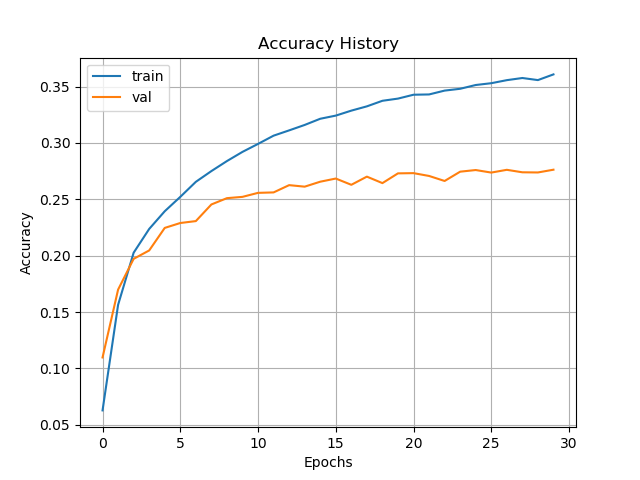

In [26]:
from IPython.display import Image
Image(filename='plots\\acc_hist_2020-03-10 02.11.17.png', height=10)

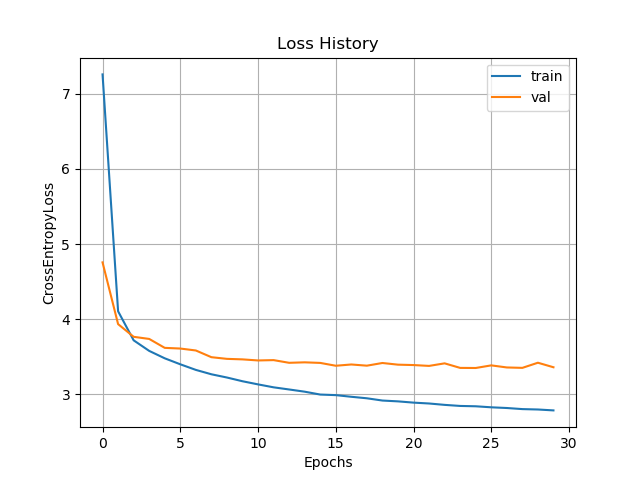

In [15]:
Image(filename='plots\\loss_hist_2020-03-10 02.11.17.png') 

## Step 3 Train Distillation model

In [7]:
!python train.py --epochs=30 --batch=100 --model=distill --memory_usage --plot_hist --teacher_file=model_standard_2.pth

Figure(640x480)
Figure(640x480)
Logging Timestamp 2020-03-10 03.02.59

Namespace(batch=100, batch_count=1, checkpoint=-1, epochs=30, memory_usage=True, model='distill', num_workers=4, opt_lr=0.001, out='saved_models/model_distill_2020-03-10 03.02.59.pth', plot_hist=True, pretrained=False, save_best=True, stop_accuracy=0.4, teacher_file='model_standard_2.pth')
device cuda:0
Batch size 100
Run training
Epoch [1/30] Time: 62.52s; BatchTime:0.06s; Loss: 3.6443; Accuracy: 0.0594; ValLoss: 2.4180; ValAccuracy: 0.1026
Epoch [2/30] Time: 62.12s; BatchTime:0.06s; Loss: 2.1138; Accuracy: 0.1480; ValLoss: 2.0158; ValAccuracy: 0.1726
Epoch [3/30] Time: 61.78s; BatchTime:0.06s; Loss: 1.9228; Accuracy: 0.1936; ValLoss: 1.9305; ValAccuracy: 0.1934
Epoch [4/30] Time: 61.74s; BatchTime:0.06s; Loss: 1.8421; Accuracy: 0.2172; ValLoss: 1.8734; ValAccuracy: 0.2078
Epoch [5/30] Time: 62.06s; BatchTime:0.06s; Loss: 1.7848; Accuracy: 0.2349; ValLoss: 1.8466; ValAccuracy: 0.2200
Epoch [6/30] Time: 62.84s; Batc

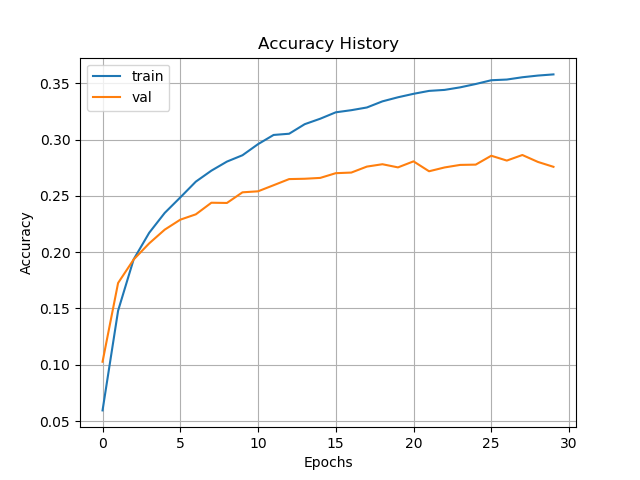

In [27]:
Image(filename='plots\\acc_hist_2020-03-10 03.02.59.png', height=10)

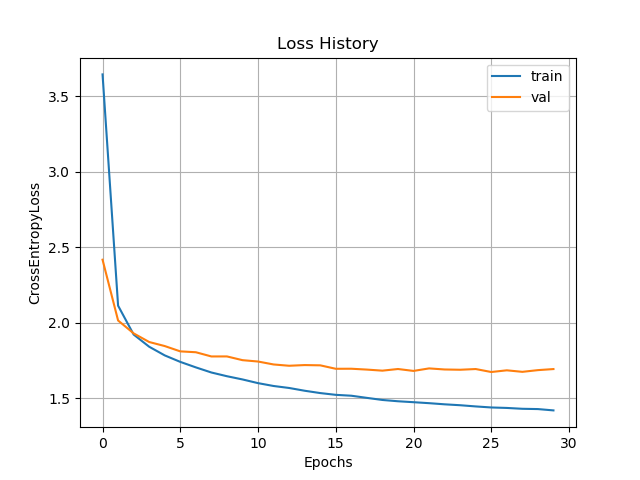

In [28]:
Image(filename='plots\\loss_hist_2020-03-10 03.02.59.png', height=10)

# DONE! 

To enable `Knowledge distillation` model you should set flag `--model=distill` and set `--teacher_file` for teacher model to load weights

## Results 
- Added specific model `DistillModel`
- Added wrappers for loss and metrics `DistillationAccuracy`, `DistillationLoss` as file `utils.py`
- We can see imrovements at model accuracy 
- Also total memory consuming stays the same

## TL;DR. Moar techniques on accuracy vs time trade-off (just for your information)

### Tensor type size

One of the hyperparameter affecting memory consumption is the precision (e.g. floating point number). The most popular choice is 32 bit however with several hacks* 16 bit arithmetics can save you approximately half of the memory without considerable loss of perfomance. This is called mixed precision training.

*https://arxiv.org/pdf/1710.03740.pdf

### Quantization

We can actually move further and use even lower precision like 8-bit integers:

* https://heartbeat.fritz.ai/8-bit-quantization-and-tensorflow-lite-speeding-up-mobile-inference-with-low-precision-a882dfcafbbd
* https://nervanasystems.github.io/distiller/quantization/
* https://arxiv.org/abs/1712.05877

### Pruning

The idea of pruning is to remove unnecessary (in terms of loss) weights. It can be measured in different ways: for example, by the norm of the weights (similar to L1 feature selection), by the magnitude of the activation or via Taylor expansion*.

One iteration of pruning consists of two steps:

1) Rank weights with some importance measure and remove the least important

2) Fine-tune the model

This approach is a bit computationally heavy but can lead to drastic (up to 150x) decrease of memory to store the weights. Moreover if you make use of structure in layers you can decrease also compute. For example, the whole convolutional filters can be removed.

*https://arxiv.org/pdf/1611.06440.pdf